In [1]:
import fiona
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from time import time
from tqdm import tqdm
import xarray as xr
import torch
import torch.nn as nn
import matplotlib.colors as colors
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

seed = 1234
np.random.seed(seed)

## 1. Read Xarray Files


In [2]:
def get_filenames(directory):
    filenames = sorted(os.listdir(directory))
    return [f for f in filenames if f.endswith(".nc")]


def get_path(directory, filename):
    return os.path.join(directory, filename)


def get_basename(path):
    return os.path.basename(path)


def get_month_year(file_name, dtype="ppt"):
    """Get month and year from file name"""
    if dtype == "ppt":
        time = pd.Timestamp("-".join(file_name.split(".")[0].split("_")[1:]))
        month, year = time.month, time.year
    elif dtype == "sst":
        year, month = file_name.split(".")[-2][-6:-2], file_name.split(".")[-2][-2:]
        month, year = int(month), int(year)
    else:
        print(f"dtype {dtype} not implemented. Use ppt or sst.")
        month, year = None, None
    return month, year


def read_xr(path, dtype="ppt"):
    """Read xarray file"""
    file_data = xr.load_dataset(path, engine="netcdf4")
    file_name = get_basename(path)
    month, year = get_month_year(file_name, dtype)
    xr_data = [file_name, year, month]

    if dtype == "ppt":
        file_data = file_data.rename_vars(
            {list(file_data.keys())[1]: "ppt", "longitude": "lon", "latitude": "lat"}
        )

        # Coarsen data to reduce resolution
        file_data = file_data.coarsen(latitude=4, longitude=4, boundary="trim").mean()
        #         file_data = file_data.sel(longitude=slice(-300, -100))

        ##Slice for west coast
        file_data = file_data.sel(longitude=slice(0, 150))

        xr_data.append(file_data.ppt.values)
        columns = list("FYMD")
        columns[-1] = "ppt"

    elif dtype == "sst":
        # Coarsen data to reduce resolution
        #         file_data = file_data.coarsen(lat = 4, lon = 4, boundary = "trim").mean()

        ##Slice for west coast
        #         file_data = file_data.sel(lon=slice(100, 400))

        xr_data.extend([file_data.sst.values, file_data.ssta.values])
        columns = list("FYMDA")
        columns[-2], columns[-1] = "sst", "ssta"

    else:
        print(f"dtype {dtype} not implemented. Use ppt or sst.")

    longitude, latitude = file_data.lon.values, file_data.lat.values
    return xr_data, longitude, latitude, columns


def load_data(directory, dtype="ppt"):
    """Load directory files in a pandas dataframe"""
    filenames = get_filenames(directory)
    data_info_list = []
    for i, file_name in tqdm(enumerate(filenames)):
        path = get_path(directory, file_name)
        xr_data, longitude, latitude, columns = read_xr(path, dtype)
        data_info_list.append(xr_data)
    df = pd.DataFrame([p for p in data_info_list], columns=columns)
    return df, latitude, longitude

#### `Change ppt_directory and sst_directory based on your directories`


In [3]:
ppt_directory = "data/ppt-nc-1895-2020"
sst_directory = "data/ERSST"

In [4]:
### Load ppt data
ppt_df, lat, lon = load_data(ppt_directory, dtype="ppt")

759it [00:11, 65.34it/s]


### PPT Levels in different U.S. States


In [5]:
def show_states(west_coast=True, state_file="States/cb_2018_us_state_20m.shp"):
    shape = fiona.open(state_file)
    for s in shape:
        pts = s["geometry"]["coordinates"]
        for p in pts:
            state = np.array(p).squeeze()
            if state[:, 1].min() < 50 and state[:, 1].min() > 22:
                if not west_coast:
                    plt.plot(state[:, 0], state[:, 1], color="black")
                elif np.max(state[:, 0]) < -100:  # plot only west coast
                    plt.plot(state[:, 0], state[:, 1], color="black")

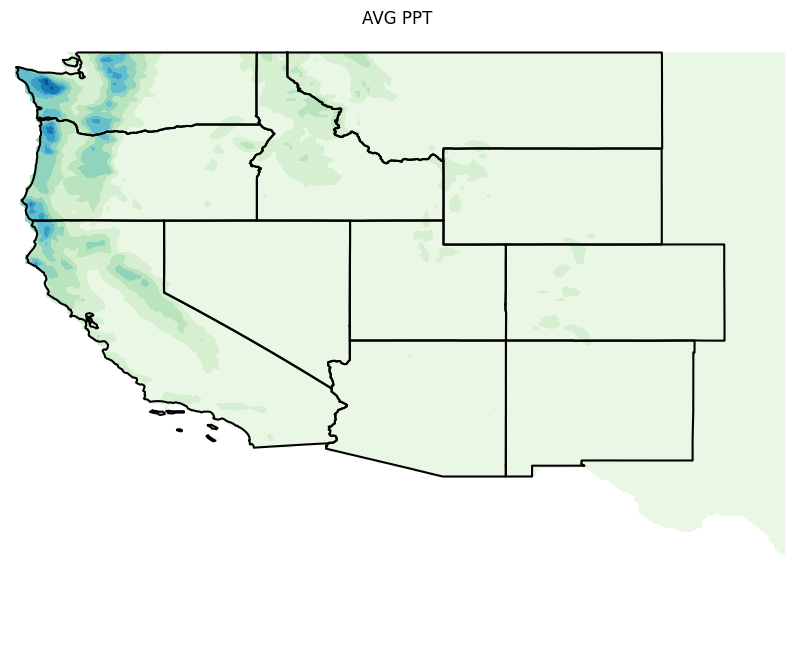

In [6]:
avg_ppt = ppt_df["ppt"].mean()

plt.figure(figsize=(10, 8))
xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, avg_ppt, cmap="GnBu")
show_states()
plt.axis("off")
plt.title("AVG PPT")
plt.show()
plt.close()

In [7]:
### Load sst data
sst_df, _, _ = load_data(sst_directory, dtype="sst")
sst_df

14it [00:00, 104.80it/s]

1644it [00:06, 253.46it/s]


,F,Y,M,sst,ssta
0,ersst.v5.188001.nc,1880,1,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1,ersst.v5.188002.nc,1880,2,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
2,ersst.v5.188003.nc,1880,3,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
3,ersst.v5.188004.nc,1880,4,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
4,ersst.v5.188005.nc,1880,5,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
...,...,...,...,...,...
1639,ersst.v5.201608.nc,2016,8,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1640,ersst.v5.201609.nc,2016,9,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1641,ersst.v5.201610.nc,2016,10,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1642,ersst.v5.201611.nc,2016,11,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...


### SST Levels


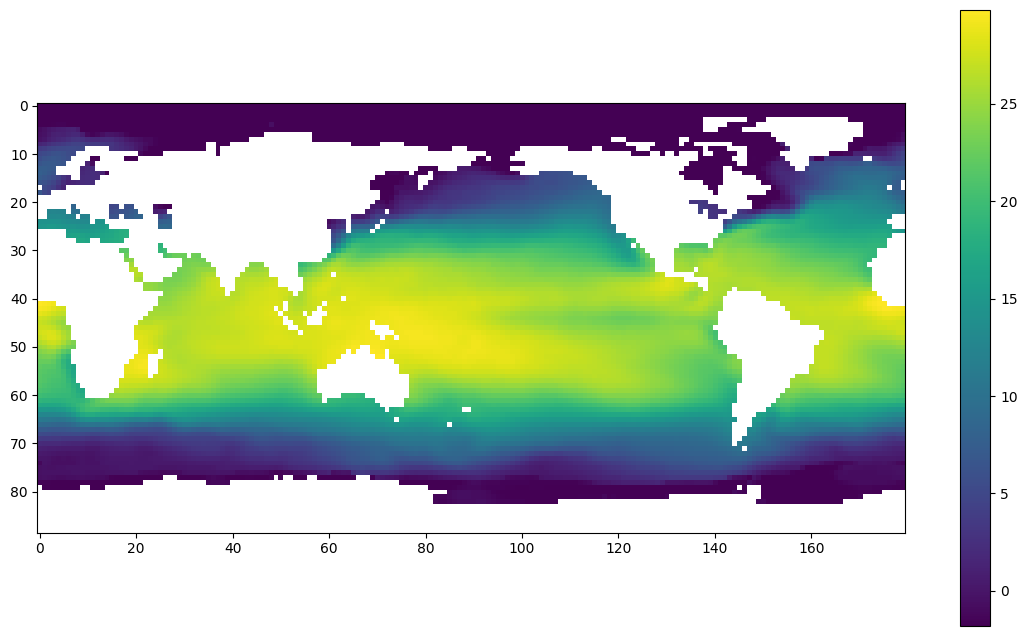

(1, 1, 89, 180)

In [8]:
plt.figure(figsize=(14, 8))
sst_example = sst_df["sst"].iloc[0]
plt.imshow(np.flipud(sst_example.reshape(sst_example.shape[-2], sst_example.shape[-1])))
plt.colorbar()
plt.show()
sst_example.shape

In [9]:
## Check shapes of ppt and sst
sst_df["sst"].iloc[0].shape, ppt_df["ppt"].iloc[0].shape

((1, 1, 89, 180), (155, 150))

In [10]:
# get rainfall month and year
rain_row = ppt_df.iloc[0]
m, y = rain_row["M"], rain_row["Y"]

# get sst month and year
sst_row = sst_df[(sst_df["M"] == m) & (sst_df["Y"] == y)]  # bitmask filters for month and year
index_position = sst_row.index[0]  # index returns Index object, so we need to get the first element

# if index_position < 24:
#     # do something, though this should never happen cuz sst starts far earlier

prev24 = sst_df.iloc[index_position - 24 : index_position]

In [11]:
import pandas as pd

# Sample DataFrame
data = {
    "month": [1, 5, 7, 5, 12],
    "year": [2020, 2021, 2021, 2022, 2020],
    "data": ["A", "B", "C", "D", "E"],  # Additional data column for illustration
}
df = pd.DataFrame(data)

# Your target month and year
target_month = 5
target_year = 2021

# Create a boolean mask to filter the DataFrame
mask = (df["month"] == target_month) & (df["year"] == target_year)

# Apply the mask to the DataFrame
filtered_df = df[mask]

# Display the filtered DataFrame
print(filtered_df)

   month  year data
1      5  2021    B


## 2. Combine SST and PPT


In [12]:
df = sst_df.merge(ppt_df, on=["Y", "M"], suffixes=("_sst", "_ppt"), how="inner")

## 3. Add Temporal Features


In [13]:
def add_time(df):
    """Add Time Column"""
    min_year = np.min(df["Y"])
    df["T"] = (df["Y"] - min_year) * 12 + df["M"]
    return df


def add_season(df):
    """adds Season Column (0 for months 1,2,3 and 1 for months 10,11,12)"""
    df["season"] = ((df["M"] - 1) // 4).astype(bool).astype(int)
    return df


df = add_season(add_time(df))
df.to_csv("data/df.csv", index=False)

### ppt has data for only months 1,2,3,10,11,12. While sst has all months.


## 4. Add Clusters


In [14]:
clusters_map = np.load("clusters.npy")

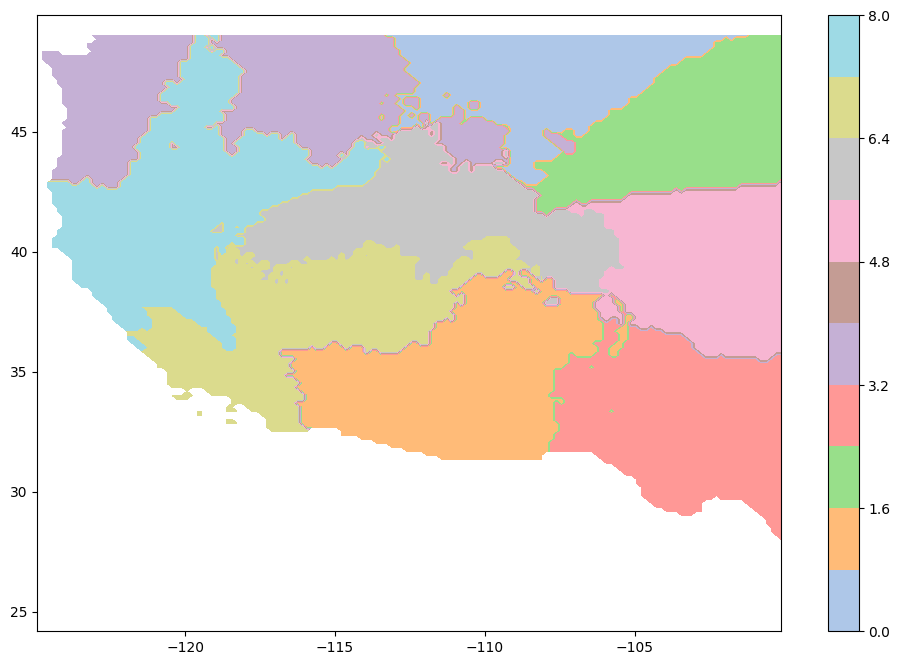

np.unique(clusters):  [ 0.  1.  2.  3.  4.  5.  6.  7.  8. nan]


In [15]:
plt.figure(figsize=(12, 8))
xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, clusters_map, levels=10, cmap="tab20")
plt.colorbar()
plt.show()
print("np.unique(clusters_map): ", np.unique(clusters_map))

In [16]:
def average_clusters(image, cluster_array, return_image=True):
    """Average the values of each cluster in the image"""
    unique_clusters = np.unique(cluster_array)  # Find unique cluster labels

    if return_image:
        # Initialize an array to store the average values
        averaged_image = np.zeros_like(image, dtype=float)
    else:
        cluster_averages = []

    for cluster_label in unique_clusters:
        # Mask the original image with the current cluster label
        masked_image = np.where(cluster_array == cluster_label, image, 0)

        # Calculate the average value for the current cluster
        cluster_size = np.sum(cluster_array == cluster_label)
        cluster_average = np.sum(masked_image) / cluster_size

        if return_image:
            # Replace pixels in the averaged image with the cluster average
            averaged_image += np.where(
                cluster_array == cluster_label, cluster_average, 0
            )
        else:
            cluster_averages.append(cluster_average)

    return averaged_image if return_image else np.array(cluster_averages)


avg_clusters = average_clusters(df.iloc[0].ppt, clusters_map)
avg_clusters

/var/folders/56/lnrgwj295yq6l00hqdbfzfmr0000gn/T/ipykernel_25979/790362116.py:17: RuntimeWarning: invalid value encountered in divide
  cluster_average = np.sum(masked_image) / cluster_size


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

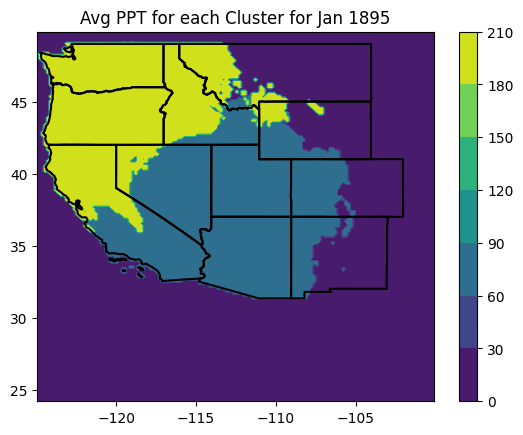

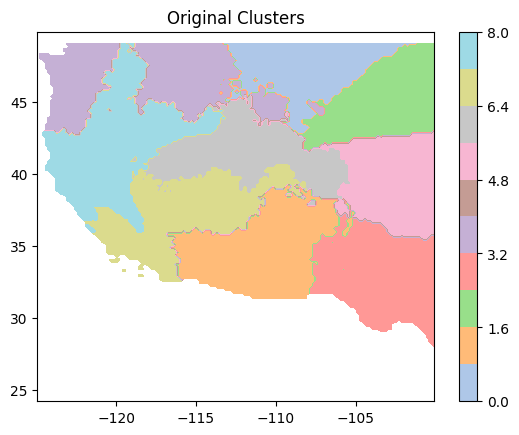

In [17]:
plt.contourf(xx, yy, avg_clusters)
plt.colorbar()
show_states()
plt.title("Avg PPT for each Cluster for Jan 1895")
plt.show()

xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, clusters_map, levels=10, cmap="tab20")
plt.colorbar()
plt.title("Original Clusters")
plt.show()

In [18]:
df["ppt_cluster"] = df["ppt"].apply(lambda x: average_clusters(x, clusters_map))
df["ppt_cluster_vector"] = df["ppt"].apply(
    lambda x: average_clusters(x, clusters_map, return_image=False)[:-1]
)

/var/folders/56/lnrgwj295yq6l00hqdbfzfmr0000gn/T/ipykernel_25979/790362116.py:17: RuntimeWarning: invalid value encountered in divide
  cluster_average = np.sum(masked_image) / cluster_size
/var/folders/56/lnrgwj295yq6l00hqdbfzfmr0000gn/T/ipykernel_25979/790362116.py:17: RuntimeWarning: invalid value encountered in divide
  cluster_average = np.sum(masked_image) / cluster_size


## 5. Add Quantiles


In [19]:
def get_quantiles(df, cluster=True):

    vector = df.ppt_cluster_vector if cluster else df.ppt

    ppt_vector = np.stack(vector.apply(lambda x: x.reshape(-1))).T
    q1 = np.quantile(ppt_vector, 0.25, axis=1, keepdims=True).flatten()
    q2 = np.quantile(ppt_vector, 0.5, axis=1, keepdims=True).flatten()
    q3 = np.quantile(ppt_vector, 0.75, axis=1, keepdims=True).flatten()
    return q1, q2, q3


q1, q2, q3 = get_quantiles(df)
q1

array([ 9.5338221 , 12.17312131,  9.24412442,  7.47316639, 94.40965887,
        8.27551748, 25.58297759, 13.8765325 , 42.52929087])

In [20]:
def get_quantized(x, q1, q2, q3):
    output = np.zeros_like(x)
    output[x <= q1] = 1
    q2_arr = np.array(x > q1) * np.array(x <= q2)
    q3_arr = np.array(x > q2) * np.array(x <= q3)
    output[q2_arr] = 2
    output[q3_arr] = 3
    output[x > q3] = 4
    return output

In [21]:
df["ppt_cluster_vector_quantized"] = df["ppt_cluster_vector"].apply(
    lambda x: get_quantized(x, q1, q2, q3)
)
df[["T", "M", "ppt_cluster_vector_quantized"]]

,T,M,ppt_cluster_vector_quantized
0,1,1,"[4.0, 4.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 4.0]"
1,2,2,"[3.0, 3.0, 3.0, 4.0, 1.0, 4.0, 2.0, 3.0, 2.0]"
2,3,3,"[2.0, 1.0, 3.0, 1.0, 1.0, 2.0, 3.0, 3.0, 2.0]"
3,10,10,"[1.0, 3.0, 1.0, 4.0, 1.0, 3.0, 1.0, 1.0, 1.0]"
4,11,11,"[4.0, 4.0, 4.0, 4.0, 2.0, 3.0, 3.0, 2.0, 1.0]"
...,...,...,...
727,1454,2,"[1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 1.0, 2.0, 1.0]"
728,1455,3,"[3.0, 1.0, 4.0, 2.0, 4.0, 4.0, 4.0, 3.0, 4.0]"
729,1462,10,"[4.0, 1.0, 4.0, 2.0, 4.0, 2.0, 4.0, 2.0, 4.0]"
730,1463,11,"[2.0, 3.0, 3.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0]"


## Organizing Data into y_labels and x_input

Want to create a dataframe of sea surface temperature input for each cluster precipitation estimation (1, 2, 3, or 4).
The input data should be 24 months worth of sea surface temperature data. This data is stored in a quadruple vector.
For each a ppt_cluster_vector quantity, grab the last 24 months of "sst" quadruple vector data information.
to test.


### Organizing Y Labels and processing ppt clusters


In [22]:
y_labels = df.loc[:,["Y", "M", "ppt_cluster_vector_quantized"]]
y_labels = y_labels.rename(columns={"M": "month", "Y": "year"})
y_labels["date"] = pd.to_datetime(y_labels[["month","year"]].assign(day=1))
y_labels["date"] = y_labels['date']

y_labels.drop(["month"], axis=1, inplace=True)
y_labels.drop(["year"], axis=1, inplace=True)
y_labels.set_index("date", inplace=True)

ppt_data = np.array(y_labels["ppt_cluster_vector_quantized"]) - 1
# get all 9 clusters in a list, where each cluster is the ith column in ppt_data
clusters = [np.array([x[i] for x in ppt_data]) for i in range(len(ppt_data[0]))]
clusters = np.array(clusters)

In [23]:
sst_condensed = sst_df.loc[:,["Y", "M", "sst"]]
sst_condensed = sst_condensed.rename(columns={"M": "month", "Y": "year"})
sst_condensed["date"] = pd.to_datetime(sst_condensed[["month","year"]].assign(day=1))
sst_condensed["date"] = sst_condensed['date']

sst_condensed.drop(["month"], axis=1, inplace=True)
sst_condensed.drop(["year"], axis=1, inplace=True)
sst_condensed.set_index("date", inplace=True)

### Process sst data for forest tree classification on entire dataset


In [24]:
x_input_rows = []
for date in y_labels.index:
    start_date = date - pd.DateOffset(months=23)
    end_date = date
    sst_in_range = np.array(sst_condensed.loc[start_date:end_date, 'sst'].tolist()) # shape here is (24, 1, 1, 89, 180)
    # print(sst_in_range.shape)
    IO_TP_sst_in_range = sst_in_range.flatten() #1 x 384480
    sst_in_range = sst_in_range[~np.isnan(sst_in_range)] # 263712
    
    x_input_rows.append({'start date': start_date, 'end date' : end_date, 'sst rows': sst_in_range})

x_input = pd.DataFrame(x_input_rows)
x_input["start date"] = x_input["start date"].dt.to_period('M')
x_input["end date"] = x_input["end date"].dt.to_period('M')
sst_data_all = np.array([xi.tolist() for xi in np.array(x_input[:]["sst rows"])])

In [25]:
sst_data_all.shape

(732, 263712)

### Process sst data for ViViT classification on entire dataset

In [45]:
x_input_rows_keep_shape = []
for date in y_labels.index:
    start_date = date - pd.DateOffset(months=23)
    end_date = date
    sst_in_range = np.array(sst_condensed.loc[start_date:end_date, 'sst'].tolist()) # shape here is (24, 1, 1, 89, 180)
    # print(sst_in_range.shape)
    
    x_input_rows_keep_shape.append({'start date': start_date, 'end date' : end_date, 'sst rows': sst_in_range})

x_input_keep_shape = pd.DataFrame(x_input_rows_keep_shape)
x_input_keep_shape["start date"] = x_input_keep_shape["start date"].dt.to_period('M')
x_input_keep_shape["end date"] = x_input_keep_shape["end date"].dt.to_period('M')
sst_data_all_keep_shape = np.array([xi.tolist() for xi in np.array(x_input_keep_shape[:]["sst rows"])])

In [68]:
sst_data_all_keep_shape = sst_data_all_keep_shape.squeeze()
sst_data_all_keep_shape.shape

(732, 24, 89, 180)

### Check if y labels are distributed


In [46]:
# put all data from y_labels into a single, one-dimensional array
ppt_data_all = np.array(y_labels["ppt_cluster_vector_quantized"]) - 1
ppt_data_all = np.array([[y for y in x] for x in ppt_data_all])
ppt_data_all.reshape(1, -1)
# count the number of times each label appears in the data
unique, counts = np.unique(ppt_data_all, return_counts=True)
d = dict(zip(unique, counts))
d

{0.0: 1647, 1.0: 1647, 2.0: 1647, 3.0: 1647}

### Process data for PCA pre-processing with regions

We need to split the data into the following regions, so we use array slicing

![](PCA_regions.png)

Now that we have the regions, we'll split the sst data into regions using these approximate coordinates we have estimated. Once the data is separated into regions, we can use principal component analysis to reduce dimensionality and assess the effect on random forest training quality.


In [47]:
sst_squeezed = np.array([sst_condensed["sst"].iloc[row].squeeze((0,1)) for row in range(len(sst_condensed))])
pca = PCA(n_components=2)

def split_and_pca(x_start, x_end, y_start, y_end):
    """Slice the SST data according to the region boundaries and perform PCA"""
    region = sst_squeezed[:, y_start:y_end, x_start:x_end] # slice according to region boundaries
    region = region.reshape(sst_squeezed.shape[0], -1) # flatten SST data into one dimension
    mean = np.nanmean(region) # need the mean to fill in nan values
    region = np.nan_to_num(region, copy=False, nan=mean) # replace nan with mean
    region = pca.fit_transform(region) # perform PCA
    return region

# IO -> data[34:55][10:67]
# TP -> data[34:55][55:143]
# NP -> data[11:32][59:128]
# WP -> data[28:49][55:84]

TP = split_and_pca(55, 144, 34, 56)
IO = split_and_pca(10, 68, 34, 56)
WP = split_and_pca(55, 85, 28, 50)
NP = split_and_pca(59, 129, 11, 33)

sst_data_all_pca = np.concatenate((TP, IO, WP, NP), axis=1)
# put back in original dataframe format
sst_condensed_pca = sst_condensed.copy()
for row in range(len(sst_condensed_pca)):
    sst_condensed_pca["sst"].iloc[row] = sst_data_all_pca[row]

sst_condensed_pca["sst"].iloc[0].shape

(8,)

Now we have to create chunks of 24 preceding months to correspond to each y label month (since we are predicting one month's ppt data based on the preceding 24 months of sst data)


In [48]:
def chunk_sst_to_label(pca_data):
    """
    Take SST data (preprocessed by PCA on each region), type is a DataFrame organized by date
    Return 732 x num_features numpy array, where each row is the 24 months of SST data (reduced to some number of dimensions by PCA) preceding the y label date
    """
    sst_24_months = []

    for date in y_labels.index:
        start_date = date - pd.DateOffset(months=23)
        end_date = date
        # get 24 months of pca sst data preceding the y label date
        sst_in_range = np.array(pca_data.loc[start_date:end_date, 'sst'].tolist()).flatten()
        # append to the list of rows
        sst_24_months.append({'start date': start_date, 'end date' : end_date, 'sst rows': sst_in_range})

    # convert to DataFrame
    sst_24_months = pd.DataFrame(sst_24_months)
    # convert dates to period
    sst_24_months["start date"] = sst_24_months["start date"].dt.to_period('M')
    sst_24_months["end date"] = sst_24_months["end date"].dt.to_period('M')
    # convert to final raw numpy array with only the sst data
    sst_24_months = np.array([xi.tolist() for xi in np.array(sst_24_months[:]["sst rows"])])
    print(f"sst_24_months shape: {sst_24_months.shape}")
    
    return sst_24_months

sst_pca = chunk_sst_to_label(sst_condensed_pca)

sst_24_months shape: (732, 192)


In [49]:
def get_cluster_data(ind):
    X_train, X_test, y_train, y_test = train_test_split(sst_pca, clusters[ind], test_size=0.1, random_state=4)
    return X_train, X_test, y_train, y_test

## Training a Random Forest

We now have our nine label clusters and our input rows as well (which contain the flattened sea surface temperature data across the globe, excluding land coordinates). We'd like to train a random forest model on these as the first iteration of trying to fit a model.


In [50]:
trials = []
conf_preds = []
conf_labels = []
importances = []
for trial in range(5):
    accuracies = []
    for i in range(len(clusters)):
        X_train, X_test, y_train, y_test = get_cluster_data(i)

        rf = RandomForestClassifier(max_depth=1, min_samples_leaf=100, n_estimators=200) # since there are only 4 possible outputs, we use a Classifier
        rf.fit(X_train, y_train)
        importances.append(rf.feature_importances_)
        y_pred = rf.predict(X_test)  # changed to X_train to see if confusion matrix still skewed

        accuracies.append(accuracy_score(y_test, y_pred))
        conf_preds.append(y_pred)
        conf_labels.append(y_test)  # changed to y_train to see if confusion matrix still skewed
    trials.append(accuracies)

trials = np.array(trials)
# get the mean accuracy for each cluster
mean_accuracies = np.mean(trials, axis=0)
# np.savetxt("_______.csv", trials, delimiter=",")


### Find Most Important Month


In [51]:
by_month = np.array(importances).reshape(45, 24, 8) # 45 clusters, 24 months, 8 features (original shape is 45 x 192)
by_month = np.mean(by_month, axis=2) # average the importances across the 8 features to get total importance for the month
by_month = np.sum(by_month, axis=0) # sum the importances across the 24 months to get total importance for all trials for that month
by_month


array([0.2975  , 0.38125 , 0.058125, 0.15375 , 0.2325  , 0.184375,
       0.3475  , 0.441875, 0.05    , 0.111875, 0.174375, 0.190625,
       0.29625 , 0.399375, 0.09875 , 0.178125, 0.20625 , 0.21375 ,
       0.37125 , 0.488125, 0.1375  , 0.16125 , 0.2475  , 0.203125])

### Find Most Important Region


In [52]:
by_region = np.array(importances).reshape(45, 24, 8) # 45 clusters, 24 months, 8 features (original shape is 45 x 192)
by_region.shape
by_region = np.mean(by_region, axis=1) # average the importances across the 24 months to get total importance for 8 features
by_region = np.sum(by_region, axis=0) # sum the importances across the 8 features to get total importance for all trials for that month
regions = [by_region[0] + by_region[1], by_region[2] + by_region[3], by_region[4] + by_region[5], by_region[6] + by_region[7]]
regions


[0.5425000000000001,
 0.5533333333333332,
 0.34062500000000007,
 0.4385416666666667]

### Graphing results


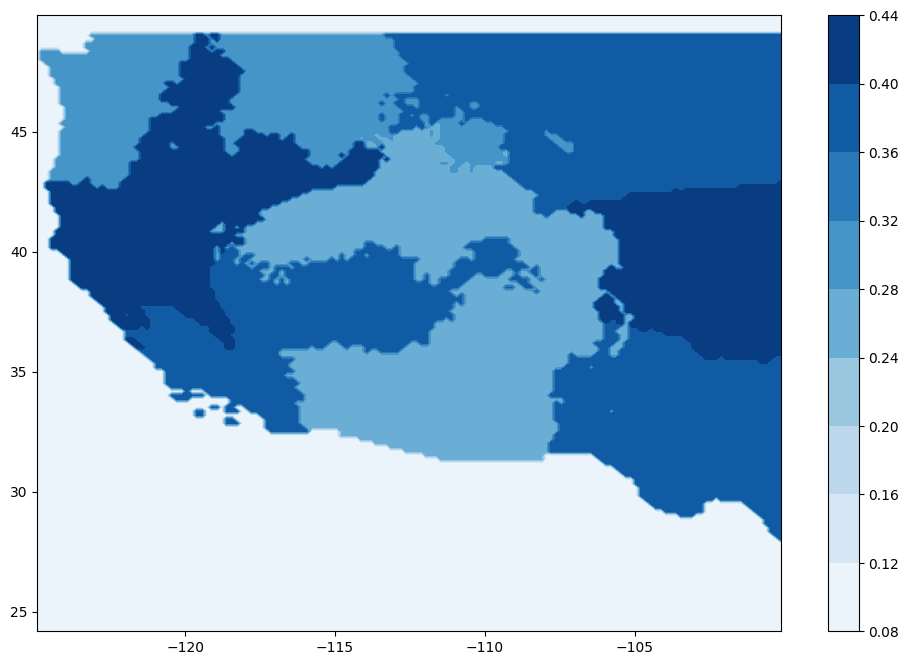

In [53]:
# clusters is 155x150 grid of values 0-8 -> convert to grid of same size with accuracy values

cluster_map_raw = np.load("clusters.npy")
cluster_map = np.where(np.isnan(cluster_map_raw), -1, cluster_map_raw)  # replace NaNs with -1
cluster_map = cluster_map.astype(int) # convert to integer
# replace all cluster numbers with their corresponding accuracy 
cluster_map = mean_accuracies[cluster_map]
cluster_map = np.where(np.isnan(cluster_map_raw), 0.1, cluster_map)  # replace where NaNs originally were with 0
plt.figure(figsize=(12, 8))
xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, cluster_map, levels=10, cmap="Blues")
plt.colorbar()
plt.show()


### Confusion Matrix


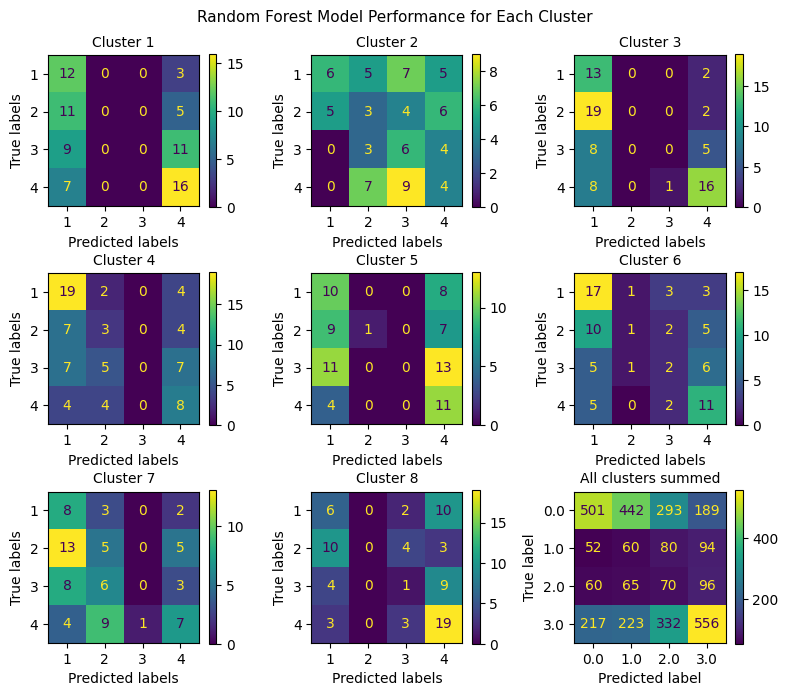

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrices(predictions, correct_labels, title=""):
    """ Plot the confusion matrices for a model for each cluster
    Args: 
        predictions (list): A list of 8 lists, where the ith list corresponds to the model predictions for cluster i+1.
        correct_labels (list): A list of 8 lists, where the ith list corresponds to the actual labels for cluster i+1
        title (str) (optioanl): A title for the figure
    """
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,7))
    spec = fig.add_gridspec(2, 4)
    flattened_axes = axes.flatten()
    for i in range(8):
        a = flattened_axes[i]
        ConfusionMatrixDisplay.from_predictions([int(x + 1) for x in correct_labels[i]], [int(x + 1) for x in predictions[i]], ax=a)
        a.set_title(label=f'Cluster {i+1}', fontdict={'fontsize':10})
        a.set_xlabel(xlabel='Predicted labels',fontdict={'fontsize':10})
        a.set_ylabel(ylabel='True labels',fontdict={'fontsize':10})
        i += 1
    ConfusionMatrixDisplay.from_predictions(np.array(predictions).flatten(),np.array(correct_labels).flatten(), ax=flattened_axes[8])
    flattened_axes[8].set_title(label="All clusters summed", fontdict={'fontsize':10})
    fig.suptitle(title, fontsize=11)
    plt.tight_layout()  
    plt.show()

plot_confusion_matrices(conf_preds, conf_labels, "Random Forest Model Performance for Each Cluster")

## Testing Hyperparameters

Use GridSearchCV library to test different values for different parameters


In [55]:
# params = {
#     'max_depth': [1,2,3,5,10,20, 50, 100, 150, 200, 500, None],
#     'min_samples_leaf': [1, 5, 10, 20, 50, 100, 200, 500],
#     'n_estimators': [10,25,30,50,100,200]
# }

# # Assuming we have a list of clusters called 'clusters'
# # and a function 'get_cluster_data' that returns X_train and y_train for a given cluster
# best_params = {}

# for i in range(len(clusters)):
#     X_train, _, y_train, _ = get_cluster_data(i)
#     # Instantiate the grid search model
#     grid_search = GridSearchCV(estimator=rf,
#                             param_grid=params,
#                             cv = 4,
#                             n_jobs=-1, verbose=1, scoring="accuracy")

#     grid_search.fit(X_train, y_train)
        
#         # Store the best parameters for the current cluster
#     best_params[i] = grid_search.best_params_
#     best_score = grid_search.best_score_
#     best_esty = grid_search.best_estimator_
#     print(f"best accuracy cluster {i}: {best_score}")
#     print(f"best estimators cluster {i}: {best_esty}")
#     print(f"best params for cluster {i}: {best_params[i]}")


## Trying Neural Network

Creating and training a logistic regression model


#### Model


In [56]:
# change to built in methods
class RainPrediction(nn.Module):
    def __init__(self, num_regions, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Dropout(0.05),
            nn.Linear(num_regions, 20),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Linear(20, num_classes)
        )

    def forward(self, x):
        return self.model(x)
    

#### Training


In [57]:
def gradient_descent(model, loss_func, train_dataset, valid_dataset, optimizer, steps=5000, batch_size=64):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    losses = []
    valid_losses = []
    for step in tqdm(range(steps)):
        model.train()
        running_loss = 0.0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            loss = loss_func(model(x_batch), y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        losses.append(avg_loss)

        model.eval()
        running_valid_loss = 0.0
        with torch.no_grad():
            for x_valid_batch, y_valid_batch in valid_loader:
                valid_loss = loss_func(model(x_valid_batch), y_valid_batch)
                running_valid_loss += valid_loss.item()
        avg_valid_loss = running_valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)

        if (step + 1) % 10 == 0:
            print(f"Step {step+1}/{steps}, Training Loss: {avg_loss}, Validation Loss: {avg_valid_loss}")

    print(f"Final training loss: {losses[-1]}")
    print(f"Final validation loss: {valid_losses[-1]}")

    return losses, valid_losses


def calculate_accuracy(model, x, y):
    model.eval()
    with torch.no_grad():
        outputs = model(x)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        return correct / total, predicted

# Iterate for all 8 clusters
nn_train_predictions_all_clusters = []
nn_test_predictions_all_clusters = []
nn_train_labels_all_clusters = []
nn_test_labels_all_clusters = []

for i in range(len(clusters)):
    print(f"\nBegin training model for cluster {i+1}")
    # Get data for this cluster
    X_train, X_test, y_train, y_test = get_cluster_data(i)

    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Initialize the model and optimizer
    model = RainPrediction(X_train.shape[1], 4)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Run the training
    losses, valid_losses = gradient_descent(
        model, nn.CrossEntropyLoss(), train_dataset, test_dataset, optimizer, steps=150
    )

    train_accuracy, nn_train_predictions = calculate_accuracy(model, X_train_tensor, y_train_tensor)
    test_accuracy, nn_test_predictions = calculate_accuracy(model, X_test_tensor, y_test_tensor)

    nn_train_predictions_all_clusters.append(nn_train_predictions.tolist())
    nn_test_predictions_all_clusters.append(nn_test_predictions.tolist())
    nn_train_labels_all_clusters.append(y_train_tensor.tolist())
    nn_test_labels_all_clusters.append(y_test_tensor.tolist())

    print(f"Training accuracy for cluster {i+1}: {train_accuracy * 100}%")
    print(f"Test accuracy for cluster {i+1}: {test_accuracy * 100}%")


Begin training model for cluster 1


  4%|▍         | 6/150 [00:00<00:02, 57.99it/s]

Step 10/150, Training Loss: 1.3578933585773816, Validation Loss: 1.3672832250595093


 21%|██▏       | 32/150 [00:00<00:01, 111.35it/s]

Step 20/150, Training Loss: 1.3183714476498691, Validation Loss: 1.3979454636573792
Step 30/150, Training Loss: 1.264428507197987, Validation Loss: 1.3642007112503052


 31%|███       | 46/150 [00:00<00:00, 120.94it/s]

Step 40/150, Training Loss: 1.2298304492777044, Validation Loss: 1.393782913684845


 39%|███▉      | 59/150 [00:00<00:00, 123.86it/s]

Step 50/150, Training Loss: 1.2078371914950283, Validation Loss: 1.3755977749824524
Step 60/150, Training Loss: 1.2057731259952893, Validation Loss: 1.3385596871376038


 49%|████▊     | 73/150 [00:00<00:00, 127.35it/s]

Step 70/150, Training Loss: 1.1578630642457441, Validation Loss: 1.420611560344696


 58%|█████▊    | 87/150 [00:00<00:00, 129.94it/s]

Step 80/150, Training Loss: 1.1669499765742908, Validation Loss: 1.4608173966407776
Step 90/150, Training Loss: 1.128885193304582, Validation Loss: 1.4231362342834473


 67%|██████▋   | 101/150 [00:00<00:00, 132.67it/s]

Step 100/150, Training Loss: 1.0960184173150496, Validation Loss: 1.4940022230148315


 77%|███████▋  | 115/150 [00:00<00:00, 132.64it/s]

Step 110/150, Training Loss: 1.0889881361614575, Validation Loss: 1.5064496397972107
Step 120/150, Training Loss: 1.0648227008906277, Validation Loss: 1.594516098499298


 86%|████████▌ | 129/150 [00:01<00:00, 130.89it/s]

Step 130/150, Training Loss: 1.0422503568909385, Validation Loss: 1.6637542247772217


100%|██████████| 150/150 [00:01<00:00, 124.53it/s]


Step 140/150, Training Loss: 1.035014277154749, Validation Loss: 1.5376108288764954
Step 150/150, Training Loss: 1.0304614468054338, Validation Loss: 1.5772783160209656
Final training loss: 1.0304614468054338
Final validation loss: 1.5772783160209656
Training accuracy for cluster 1: 55.319148936170215%
Test accuracy for cluster 1: 32.432432432432435%

Begin training model for cluster 2


  9%|▉         | 14/150 [00:00<00:01, 135.70it/s]

Step 10/150, Training Loss: 1.391619010405107, Validation Loss: 1.4310320615768433


 19%|█▊        | 28/150 [00:00<00:00, 133.70it/s]

Step 20/150, Training Loss: 1.3867463198575107, Validation Loss: 1.4688371419906616
Step 30/150, Training Loss: 1.3556635054675015, Validation Loss: 1.4543418288230896


 28%|██▊       | 42/150 [00:00<00:00, 135.41it/s]

Step 40/150, Training Loss: 1.330713532187722, Validation Loss: 1.437199056148529


 37%|███▋      | 56/150 [00:00<00:00, 136.62it/s]

Step 50/150, Training Loss: 1.3139420422640713, Validation Loss: 1.4826567769050598
Step 60/150, Training Loss: 1.3108192899010398, Validation Loss: 1.5670194625854492


 47%|████▋     | 70/150 [00:00<00:00, 135.80it/s]

Step 70/150, Training Loss: 1.2952312989668413, Validation Loss: 1.6838099956512451


 56%|█████▌    | 84/150 [00:00<00:00, 136.54it/s]

Step 80/150, Training Loss: 1.2848487333817915, Validation Loss: 1.5884915590286255
Step 90/150, Training Loss: 1.213175741108981, Validation Loss: 1.6755684614181519


 66%|██████▌   | 99/150 [00:00<00:00, 137.69it/s]

Step 100/150, Training Loss: 1.19499718059193, Validation Loss: 1.6558955907821655


 85%|████████▍ | 127/150 [00:00<00:00, 137.15it/s]

Step 110/150, Training Loss: 1.1908222436904907, Validation Loss: 1.6395917534828186
Step 120/150, Training Loss: 1.1782348372719504, Validation Loss: 1.6265308856964111
Step 130/150, Training Loss: 1.1351331038908525, Validation Loss: 1.703285276889801


100%|██████████| 150/150 [00:01<00:00, 137.23it/s]


Step 140/150, Training Loss: 1.160876902666959, Validation Loss: 1.732895851135254
Step 150/150, Training Loss: 1.103089538487521, Validation Loss: 1.8366968631744385
Final training loss: 1.103089538487521
Final validation loss: 1.8366968631744385
Training accuracy for cluster 2: 51.671732522796354%
Test accuracy for cluster 2: 28.37837837837838%

Begin training model for cluster 3


  9%|▊         | 13/150 [00:00<00:01, 129.90it/s]

Step 10/150, Training Loss: 1.2743795134804465, Validation Loss: 1.2503793239593506


 17%|█▋        | 26/150 [00:00<00:01, 121.48it/s]

Step 20/150, Training Loss: 1.188065225427801, Validation Loss: 1.2648022770881653
Step 30/150, Training Loss: 1.2026323405179111, Validation Loss: 1.2563090324401855


 26%|██▌       | 39/150 [00:00<00:00, 123.85it/s]

Step 40/150, Training Loss: 1.1598318923603406, Validation Loss: 1.2467550039291382


 44%|████▍     | 66/150 [00:00<00:00, 127.70it/s]

Step 50/150, Training Loss: 1.1444735418666492, Validation Loss: 1.2851858139038086
Step 60/150, Training Loss: 1.122886446389285, Validation Loss: 1.288483440876007
Step 70/150, Training Loss: 1.1070872816172512, Validation Loss: 1.4542067050933838


 62%|██████▏   | 93/150 [00:00<00:00, 128.42it/s]

Step 80/150, Training Loss: 1.096788536418568, Validation Loss: 1.263478696346283
Step 90/150, Training Loss: 1.0612805594097485, Validation Loss: 1.4347633719444275
Step 100/150, Training Loss: 1.0709130276333203, Validation Loss: 1.3816415667533875


 80%|████████  | 120/150 [00:00<00:00, 128.40it/s]

Step 110/150, Training Loss: 1.0607553720474243, Validation Loss: 1.4474602937698364
Step 120/150, Training Loss: 1.022473470731215, Validation Loss: 1.4814804196357727


 89%|████████▊ | 133/150 [00:01<00:00, 127.52it/s]

Step 130/150, Training Loss: 1.026758768341758, Validation Loss: 1.4337886571884155


100%|██████████| 150/150 [00:01<00:00, 127.91it/s]


Step 140/150, Training Loss: 0.9946569041772322, Validation Loss: 1.6485840678215027
Step 150/150, Training Loss: 0.964799778027968, Validation Loss: 1.708394706249237
Final training loss: 0.964799778027968
Final validation loss: 1.708394706249237
Training accuracy for cluster 3: 50.75987841945289%
Test accuracy for cluster 3: 39.189189189189186%

Begin training model for cluster 4


  9%|▊         | 13/150 [00:00<00:01, 129.30it/s]

Step 10/150, Training Loss: 1.3383975137363782, Validation Loss: 1.3543848991394043


 17%|█▋        | 26/150 [00:00<00:00, 124.61it/s]

Step 20/150, Training Loss: 1.3110950751738115, Validation Loss: 1.3424147367477417
Step 30/150, Training Loss: 1.246416373686357, Validation Loss: 1.3196925520896912


 33%|███▎      | 49/150 [00:00<00:01, 73.38it/s] 

Step 40/150, Training Loss: 1.236788803880865, Validation Loss: 1.3185087442398071
Step 50/150, Training Loss: 1.2034693631258877, Validation Loss: 1.3055489659309387


 49%|████▊     | 73/150 [00:00<00:00, 94.19it/s]

Step 60/150, Training Loss: 1.1721866564317183, Validation Loss: 1.2776806354522705
Step 70/150, Training Loss: 1.1661300550807605, Validation Loss: 1.3063595294952393
Step 80/150, Training Loss: 1.1342801722613247, Validation Loss: 1.334877371788025


 75%|███████▍  | 112/150 [00:01<00:00, 115.11it/s]

Step 90/150, Training Loss: 1.1307802200317383, Validation Loss: 1.3600279092788696
Step 100/150, Training Loss: 1.0885399688373913, Validation Loss: 1.4371563792228699
Step 110/150, Training Loss: 1.0701010660691694, Validation Loss: 1.3682924509048462


 92%|█████████▏| 138/150 [00:01<00:00, 121.59it/s]

Step 120/150, Training Loss: 1.057898846539584, Validation Loss: 1.5205863118171692
Step 130/150, Training Loss: 1.050894477150657, Validation Loss: 1.493704378604889
Step 140/150, Training Loss: 1.016033644025976, Validation Loss: 1.541509747505188


100%|██████████| 150/150 [00:01<00:00, 106.38it/s]


Step 150/150, Training Loss: 1.0067060860720547, Validation Loss: 1.5651021003723145
Final training loss: 1.0067060860720547
Final validation loss: 1.5651021003723145
Training accuracy for cluster 4: 59.87841945288754%
Test accuracy for cluster 4: 39.189189189189186%

Begin training model for cluster 5


  8%|▊         | 12/150 [00:00<00:01, 118.03it/s]

Step 10/150, Training Loss: 1.3646508563648572, Validation Loss: 1.4039667844772339
Step 20/150, Training Loss: 1.2844961556521328, Validation Loss: 1.4892413020133972


 17%|█▋        | 25/150 [00:00<00:01, 123.71it/s]

Step 30/150, Training Loss: 1.2502304207194934, Validation Loss: 1.548457145690918


 34%|███▍      | 51/150 [00:00<00:00, 123.81it/s]

Step 40/150, Training Loss: 1.2440816380760886, Validation Loss: 1.5472102165222168
Step 50/150, Training Loss: 1.2165090712634, Validation Loss: 1.5591256618499756


 43%|████▎     | 65/150 [00:00<00:00, 127.52it/s]

Step 60/150, Training Loss: 1.1764035766774958, Validation Loss: 1.6109923124313354


 53%|█████▎    | 79/150 [00:00<00:00, 129.62it/s]

Step 70/150, Training Loss: 1.1734632145274768, Validation Loss: 1.6658991575241089
Step 80/150, Training Loss: 1.1496823592619463, Validation Loss: 1.6304535269737244


 61%|██████▏   | 92/150 [00:00<00:00, 126.28it/s]

Step 90/150, Training Loss: 1.095455977049741, Validation Loss: 1.6420714259147644


 70%|███████   | 105/150 [00:00<00:00, 124.65it/s]

Step 100/150, Training Loss: 1.0859379930929705, Validation Loss: 1.6547012329101562
Step 110/150, Training Loss: 1.0504085638306357, Validation Loss: 1.7060556411743164


 79%|███████▊  | 118/150 [00:00<00:00, 125.08it/s]

Step 120/150, Training Loss: 1.0138604749332776, Validation Loss: 1.7016713619232178


 97%|█████████▋| 145/150 [00:01<00:00, 129.65it/s]

Step 130/150, Training Loss: 1.0153992880474438, Validation Loss: 1.8022622466087341
Step 140/150, Training Loss: 1.0002815127372742, Validation Loss: 1.9025826454162598


100%|██████████| 150/150 [00:01<00:00, 126.26it/s]


Step 150/150, Training Loss: 0.9801093990152533, Validation Loss: 1.9177889823913574
Final training loss: 0.9801093990152533
Final validation loss: 1.9177889823913574
Training accuracy for cluster 5: 61.702127659574465%
Test accuracy for cluster 5: 20.27027027027027%

Begin training model for cluster 6


  9%|▊         | 13/150 [00:00<00:01, 124.60it/s]

Step 10/150, Training Loss: 1.3639932870864868, Validation Loss: 1.3620463013648987
Step 20/150, Training Loss: 1.2549558227712458, Validation Loss: 1.3235066533088684


 17%|█▋        | 26/150 [00:00<00:01, 123.39it/s]

Step 30/150, Training Loss: 1.2377670136365024, Validation Loss: 1.3176047205924988


 35%|███▌      | 53/150 [00:00<00:00, 122.63it/s]

Step 40/150, Training Loss: 1.1887336861003528, Validation Loss: 1.2972743511199951
Step 50/150, Training Loss: 1.1764321435581555, Validation Loss: 1.3148241639137268


 45%|████▍     | 67/150 [00:00<00:00, 127.03it/s]

Step 60/150, Training Loss: 1.1673221046274358, Validation Loss: 1.3372519612312317


 54%|█████▍    | 81/150 [00:00<00:00, 129.95it/s]

Step 70/150, Training Loss: 1.1436855792999268, Validation Loss: 1.3129644393920898
Step 80/150, Training Loss: 1.143827416680076, Validation Loss: 1.3580728769302368


 63%|██████▎   | 95/150 [00:00<00:00, 126.07it/s]

Step 90/150, Training Loss: 1.0879578048532659, Validation Loss: 1.4665148258209229


 79%|███████▉  | 119/150 [00:01<00:00, 90.45it/s]

Step 100/150, Training Loss: 1.0956512581218372, Validation Loss: 1.499527096748352
Step 110/150, Training Loss: 1.0487148653377185, Validation Loss: 1.448734998703003
Step 120/150, Training Loss: 1.0559879270466892, Validation Loss: 1.4936892986297607


100%|██████████| 150/150 [00:01<00:00, 110.68it/s]


Step 130/150, Training Loss: 1.032744358886372, Validation Loss: 1.5314918756484985
Step 140/150, Training Loss: 1.0260783271356062, Validation Loss: 1.5889443755149841
Step 150/150, Training Loss: 1.0187406160614707, Validation Loss: 1.5686659812927246
Final training loss: 1.0187406160614707
Final validation loss: 1.5686659812927246
Training accuracy for cluster 6: 53.64741641337386%
Test accuracy for cluster 6: 39.189189189189186%

Begin training model for cluster 7


 17%|█▋        | 26/150 [00:00<00:00, 124.25it/s]

Step 10/150, Training Loss: 1.3901857246052136, Validation Loss: 1.3521075248718262
Step 20/150, Training Loss: 1.3493583744222468, Validation Loss: 1.4162001609802246
Step 30/150, Training Loss: 1.327413103797219, Validation Loss: 1.5724895000457764


 44%|████▍     | 66/150 [00:00<00:00, 129.49it/s]

Step 40/150, Training Loss: 1.3413174910978838, Validation Loss: 1.5236271023750305
Step 50/150, Training Loss: 1.3146613402800127, Validation Loss: 1.6144031286239624
Step 60/150, Training Loss: 1.3020768599076704, Validation Loss: 1.5541298389434814


 62%|██████▏   | 93/150 [00:00<00:00, 128.50it/s]

Step 70/150, Training Loss: 1.2730538086457686, Validation Loss: 1.7661835551261902
Step 80/150, Training Loss: 1.262291138822382, Validation Loss: 1.7998186349868774
Step 90/150, Training Loss: 1.247962398962541, Validation Loss: 2.051947057247162


 79%|███████▉  | 119/150 [00:00<00:00, 125.37it/s]

Step 100/150, Training Loss: 1.2327235828746448, Validation Loss: 1.9541258215904236
Step 110/150, Training Loss: 1.1901680772954768, Validation Loss: 1.9988043308258057
Step 120/150, Training Loss: 1.1886956908486106, Validation Loss: 1.9167580008506775


100%|██████████| 150/150 [00:01<00:00, 126.25it/s]


Step 130/150, Training Loss: 1.1445129134438254, Validation Loss: 2.096125066280365
Step 140/150, Training Loss: 1.1620992747220127, Validation Loss: 2.023444712162018
Step 150/150, Training Loss: 1.1797983104532415, Validation Loss: 2.0659819841384888
Final training loss: 1.1797983104532415
Final validation loss: 2.0659819841384888
Training accuracy for cluster 7: 48.02431610942249%
Test accuracy for cluster 7: 27.027027027027028%

Begin training model for cluster 8


 19%|█▊        | 28/150 [00:00<00:00, 128.70it/s]

Step 10/150, Training Loss: 1.3047512444582852, Validation Loss: 1.5399015545845032
Step 20/150, Training Loss: 1.3081682920455933, Validation Loss: 1.462646245956421
Step 30/150, Training Loss: 1.27462514964017, Validation Loss: 1.5101150274276733


 36%|███▌      | 54/150 [00:00<00:00, 124.72it/s]

Step 40/150, Training Loss: 1.224112098867243, Validation Loss: 1.5476691722869873
Step 50/150, Training Loss: 1.222592137076638, Validation Loss: 1.4856747388839722
Step 60/150, Training Loss: 1.2225857214494185, Validation Loss: 1.6195266246795654


 63%|██████▎   | 95/150 [00:00<00:00, 130.82it/s]

Step 70/150, Training Loss: 1.1717703559181907, Validation Loss: 1.614618957042694
Step 80/150, Training Loss: 1.1171672452579846, Validation Loss: 1.783598244190216
Step 90/150, Training Loss: 1.1058614579114048, Validation Loss: 1.7881417870521545


 73%|███████▎  | 109/150 [00:00<00:00, 90.50it/s]

Step 100/150, Training Loss: 1.1178701519966125, Validation Loss: 1.7385882139205933


 88%|████████▊ | 132/150 [00:01<00:00, 100.60it/s]

Step 110/150, Training Loss: 1.042702078819275, Validation Loss: 1.9781469106674194
Step 120/150, Training Loss: 1.0358301672068508, Validation Loss: 1.735422968864441
Step 130/150, Training Loss: 1.0321494991129094, Validation Loss: 1.7933164834976196


100%|██████████| 150/150 [00:01<00:00, 111.35it/s]


Step 140/150, Training Loss: 0.9705063971606168, Validation Loss: 1.9318286180496216
Step 150/150, Training Loss: 0.9972928003831343, Validation Loss: 1.9969426989555359
Final training loss: 0.9972928003831343
Final validation loss: 1.9969426989555359
Training accuracy for cluster 8: 60.790273556231%
Test accuracy for cluster 8: 24.324324324324326%

Begin training model for cluster 9


  9%|▊         | 13/150 [00:00<00:01, 124.50it/s]

Step 10/150, Training Loss: 1.300199194387956, Validation Loss: 1.3763371706008911


 17%|█▋        | 26/150 [00:00<00:00, 125.98it/s]

Step 20/150, Training Loss: 1.2253742001273416, Validation Loss: 1.3749967813491821
Step 30/150, Training Loss: 1.2117824446071277, Validation Loss: 1.3851974606513977


 26%|██▌       | 39/150 [00:00<00:00, 123.66it/s]

Step 40/150, Training Loss: 1.1801615953445435, Validation Loss: 1.4528273940086365


 43%|████▎     | 65/150 [00:00<00:00, 124.81it/s]

Step 50/150, Training Loss: 1.154645648869601, Validation Loss: 1.4913769960403442
Step 60/150, Training Loss: 1.1065091328187422, Validation Loss: 1.4970402717590332
Step 70/150, Training Loss: 1.083099896257574, Validation Loss: 1.442617118358612


 61%|██████    | 91/150 [00:00<00:00, 123.98it/s]

Step 80/150, Training Loss: 1.0938295722007751, Validation Loss: 1.5352323055267334
Step 90/150, Training Loss: 1.0616019801660017, Validation Loss: 1.544721245765686


 69%|██████▉   | 104/150 [00:00<00:00, 123.70it/s]

Step 100/150, Training Loss: 1.010532026941126, Validation Loss: 1.509071171283722


 78%|███████▊  | 117/150 [00:00<00:00, 124.58it/s]

Step 110/150, Training Loss: 1.0361080440607937, Validation Loss: 1.4542918801307678
Step 120/150, Training Loss: 1.020437939600511, Validation Loss: 1.6643502116203308


 87%|████████▋ | 130/150 [00:01<00:00, 122.47it/s]

Step 130/150, Training Loss: 0.9674697735092856, Validation Loss: 1.569835364818573
Step 140/150, Training Loss: 0.9795173785903237, Validation Loss: 1.617431879043579


100%|██████████| 150/150 [00:01<00:00, 111.95it/s]

Step 150/150, Training Loss: 0.9740663821047003, Validation Loss: 1.6995397210121155
Final training loss: 0.9740663821047003
Final validation loss: 1.6995397210121155
Training accuracy for cluster 9: 64.28571428571429%
Test accuracy for cluster 9: 25.675675675675674%


### Plot Neural Network Confusion Matrices


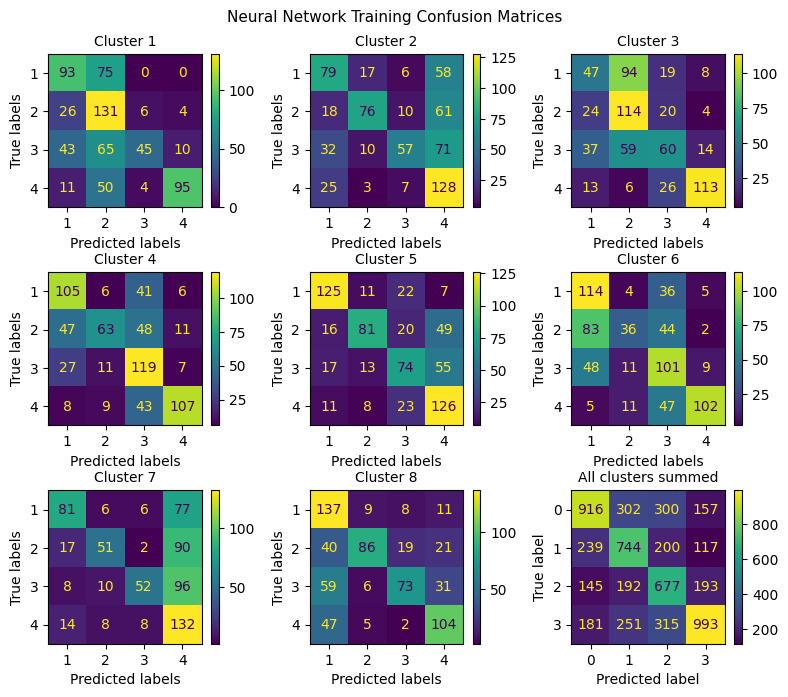

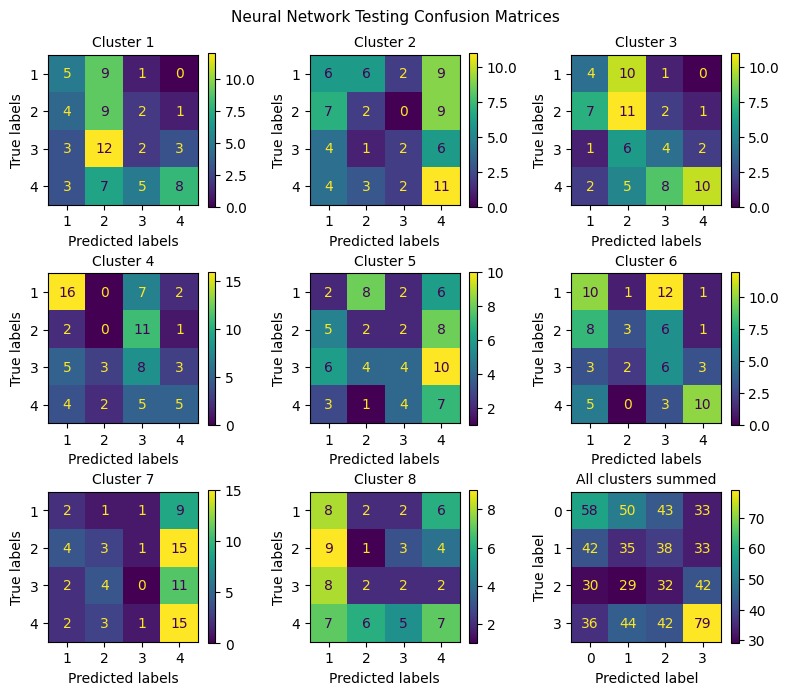

In [58]:
plot_confusion_matrices(nn_train_predictions_all_clusters,nn_train_labels_all_clusters,title="Neural Network Training Confusion Matrices")
plot_confusion_matrices(nn_test_predictions_all_clusters,nn_test_labels_all_clusters, title="Neural Network Testing Confusion Matrices")

### Plot Training and Validation Loss


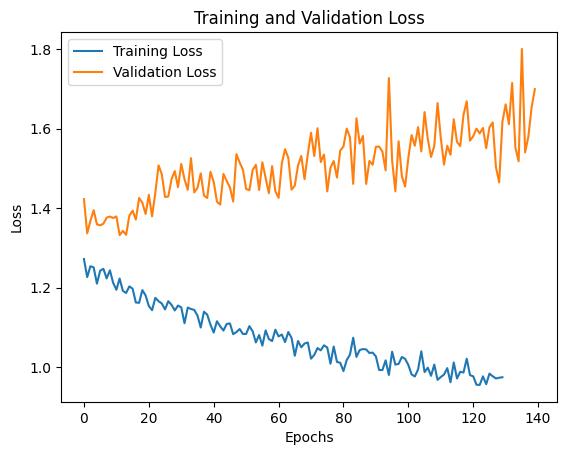

In [59]:
# Plot and label the training and validation loss values
plt.plot(losses[20:], label='Training Loss')
plt.plot(valid_losses[10:], label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Display the plot
plt.legend(loc='best')
plt.show()

### Implement Logistic Regression


/Users/hayleywalters/Desktop/MLResearch/ML_rain_prediction/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/hayleywalters/Desktop/MLResearch/ML_rain_prediction/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver 

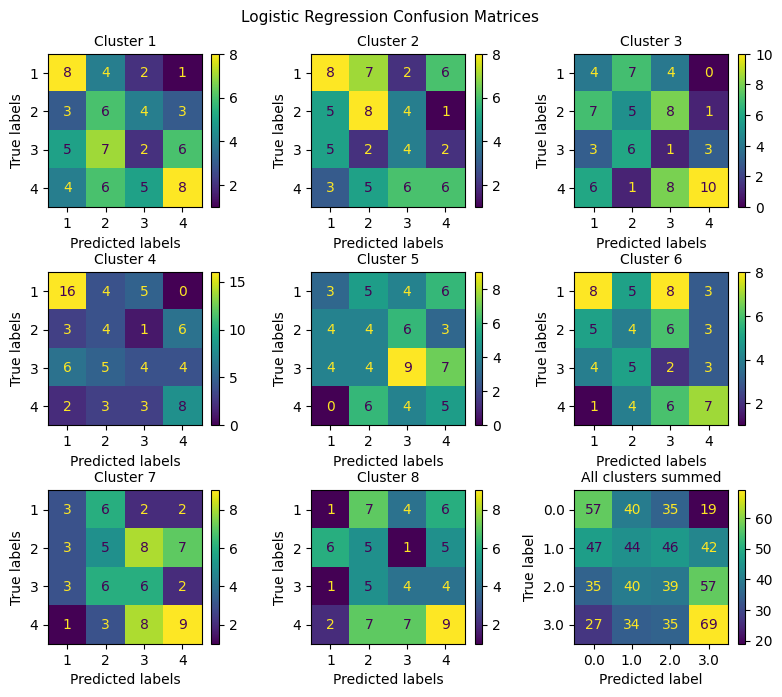

In [60]:
model = LogisticRegression()

test_preds = []
test_labels = []

for i in range(len(clusters)):
# Get data for this cluster
    X_train, X_test, y_train, y_test = get_cluster_data(i)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    test_preds.append(preds.tolist())
    test_labels.append(y_test.tolist())

plot_confusion_matrices(test_preds, test_labels,title="Logistic Regression Confusion Matrices")

# Save sst data for Cluster 1 to NPZ file, for ViViT use

In [61]:
npz_x_data = sst_data_all_keep_shape.squeeze()
npz_y_data = clusters[0]

print(npz_y_data.shape)

train_images, temp_test_images, train_labels, temp_test_labels = train_test_split(npz_x_data, npz_y_data, test_size=0.2)
val_images, test_images, val_labels, test_labels = train_test_split(temp_test_images, temp_test_labels, test_size=0.9)

np.savez('data/cluster_1_sst.npz', train_images=train_images, train_labels=train_labels, test_images=test_images, 
         test_labels=test_labels, val_images=val_images, val_labels=val_labels)


(732,)


In [62]:
import vivit

# Get the dataset
prepared_dataset = vivit.download_and_prepare_dataset("data/cluster_1_sst.npz")
(train_videos, train_labels) = prepared_dataset[0]
(valid_videos, valid_labels) = prepared_dataset[1]
(test_videos, test_labels) = prepared_dataset[2]

print(f'train_videos {train_videos.shape}, train_labels {train_labels.shape}')
print(f'valid_videos {valid_videos.shape}, valid_labels {valid_labels.shape}')
print(f'test_videos {test_videos.shape}, test_labels {test_labels.shape}')

trainloader = vivit.prepare_dataloader(train_videos, train_labels, "train")
print("done with trainloader")
validloader = vivit.prepare_dataloader(valid_videos, valid_labels, "valid")
print("done with validloader")
testloader = vivit.prepare_dataloader(test_videos, test_labels, "test")
print("done with testloader")

train_videos (585, 24, 89, 180), train_labels (585,)
valid_videos (14, 24, 89, 180), valid_labels (14,)
test_videos (133, 24, 89, 180), test_labels (133,)
done with trainloader
done with validloader
done with testloader


In [63]:
model = vivit.run_experiment(trainloader, testloader, validloader)

Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.2173 - loss: 1.6703 - top-5-accuracy: 1.0000 - val_accuracy: 0.1429 - val_loss: 1.4495 - val_top-5-accuracy: 1.0000
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.2715 - loss: 1.3883 - top-5-accuracy: 1.0000 - val_accuracy: 0.1429 - val_loss: 1.4642 - val_top-5-accuracy: 1.0000
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.2634 - loss: 1.4102 - top-5-accuracy: 1.0000 - val_accuracy: 0.1429 - val_loss: 1.4102 - val_top-5-accuracy: 1.0000
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.2593 - loss: 1.3959 - top-5-accuracy: 1.0000 - val_accuracy: 0.1429 - val_loss: 1.5861 - val_top-5-accuracy: 1.0000
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.2613 - loss: 1.4315 - top-5-accuracy: 1.0000 - val_accuracy: 0.1429 - val_loss: 1.5505 - val_top-5-accuracy: 1.0000
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.2590 - loss: 1.4213 - top-5-accuracy

In [66]:
test_loss, test_acc, _ = model.evaluate(testloader)
print(f'Testing Loss: {test_loss}, Testing Accuracy: {test_acc}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 827ms/step - accuracy: 0.2512 - loss: 1.4048 - top-5-accuracy: 1.0000
Testing Loss: 1.4277479648590088, Testing Accuracy: 0.21052631735801697
